In [1]:
%load_ext autoreload

In [54]:
%autoreload 2
import logging
import seaborn as sns
import numpy as np
import cmdstanpy

from baynes.plotter import FitPlotter
from baynes.toyMC import SpectraSampler
from baynes.analysis import standard_analysis, multithreaded_run
from baynes.probability import HoSpectrum, hdi, ptolemy
from baynes.model_utils import get_model
from numba import njit

from sympy import symbols, sin, diff, erf, exp, sqrt, Piecewise, And
from sympy.utilities.lambdify import lambdify
from scipy.special import gamma
from scipy.constants import elementary_charge, hbar, c, electron_mass


import matplotlib.pyplot as plt

cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
coeffs = np.loadtxt("parameters.dat")[:,1:]



In [82]:
def allowed_beta(E, m_nu, Q=18589.6, Z=1):
    me = 510998.95
    p = np.sqrt(E**2+E*me)
    alpha = 1/137
    eta = Z* alpha * E/p
    F = 2*np.pi/(1-np.exp(-2*np.pi*eta))
    return F*p*(E+me)*(Q-E)*np.sqrt(np.clip((Q - E) ** 2 - m_nu**2, 0, None)) + 1e-8


def allowed_betasy():
    E = symbols("E")
    m_nu, Q = symbols("m_nu, Q")
    me = 510998.95
    p = sqrt(E**2+E*me)
    alpha = 1/137
    eta = alpha * E/p
    F = 2*np.pi/(1-exp(-2*np.pi*eta))
    return Piecewise((F*p*(E+me)*(Q-E)*sqrt((Q - E) ** 2 - m_nu**2), And(Q-E>=m_nu, m_nu>=0, Q>=0)),(0, True))+1e-8


m_nu = symbols("m_nu")
E = symbols("E")
Q = symbols("Q")
partial_m_beta = diff(allowed_betasy(), m_nu)
dens_beta = 1/allowed_betasy() * (partial_m_beta**2)
f_beta = lambdify((E, m_nu, Q), dens_beta, "numpy")

In [56]:
def ptolemysym(coeffs):
    """Compute the b-decay spectrum of tritium in graphene."""
    E = symbols("E")
    y = symbols("y")
    m_nu, Q = symbols("m_nu, Q")
    me = 510998.95
    mhe3 = 2809413505.67592
    lambda_val = 4.21e-5
    eps0 = 5.76

    i_disc = lambda_val / (2 * np.pi**3)
    pb = sqrt(E**2 + 2 * E * me)

    y = 0
    for k in range(64):
        Qn = Q - coeffs[k][0]
        pn = coeffs[k][1]
        an = coeffs[k][2]
        bn = coeffs[k][3]
        cn = coeffs[k][4]
        E_nu = Qn - E
        xb = (pb - pn) / pn
        y += Piecewise((i_disc * pb * (E + me) * sqrt(E_nu**2 -m_nu**2) * E_nu * (an + xb * lambda_val * pn * (2 * bn - lambda_val * pn * cn)), E_nu>=m_nu), (0, True))

    i_cont = 1 / (np.pi**(7 / 2))
    QKE = Q - E - eps0
    b = -pb + sqrt(2 * mhe3 * (QKE - m_nu))
    bl = b * lambda_val
    pl = pb * lambda_val
    expbl = exp(-bl**2)
    exppl = exp(-pl**2)
    erfplbl = erf(pl) + erf(bl)
    pb2_2mhe3 = pb**2 / (2 * mhe3)
    kinf2 = sqrt(1 - (m_nu / (4.0 + QKE - pb2_2mhe3))**2)
    I0 = sqrt(np.pi) / (2 * lambda_val) * pb * (QKE - pb2_2mhe3)**2 * erfplbl
    I1 = 1 / (2 * lambda_val**2) * (QKE - pb2_2mhe3) * (QKE - 5.0 * pb2_2mhe3) * (exppl - expbl)
    I2 = 1 / (4 * lambda_val**3) * ((5.0 * pb2_2mhe3  - 3.0 * QKE)* pb / mhe3) * (
            -2 * pl * exppl - 2 * bl * expbl + sqrt(np.pi) * erfplbl)
    I3 = 1 / (2 * lambda_val**4) * ((5.0 * pb2_2mhe3 - QKE )/ mhe3) * (
            exppl * (1 + pl**2) - expbl * (1 + bl**2))
    I4 = 5 * pb / (32 * mhe3**2 * lambda_val**5) * (
            -expbl * (6 * bl + 4 * bl**3) - exppl * (6.0 * pl + 4 * pl**3) + 3 * sqrt(np.pi) * erfplbl)
    I5 = 1 / (8 * mhe3**2 * lambda_val**6) * (exppl * (2 + 2 * pl**2 + pl**4) - expbl * (2.0 + 2.0 * bl**2 + bl**4))
    y += Piecewise((i_cont * (E + me) * kinf2 * (I0 + I1 + I2 + I3 + I4 + I5), QKE>=m_nu), (0, True)) + 1e-8

    return y

m_nu = symbols("m_nu")
E = symbols("E")
Q = symbols("Q")

partial_m_pt = diff(ptolemysym(coeffs), m_nu)
dens_pt = 1/ptolemysym(coeffs) * (partial_m_pt**2)
f_pt = lambdify((E, m_nu, Q), dens_pt, "numpy")


TypeError: cannot determine truth value of Relational

<lambdifygenerated-11>:2: RuntimeWarning: invalid value encountered in sqrt
  return select([logical_and.reduce((greater_equal(Q, 0),greater_equal(m_nu, 0),less_equal(m_nu, -E + Q))),True], [5.26768455218814e+18*m_nu**2*(-E + Q)**2*(1.95695118355918e-6*E + 1)**2*(1.95695118355918e-6*E**2 + E)/((1 - exp(-6.41577754697401e-5*E/sqrt(1.95695118355918e-6*E**2 + E)))**2*(-m_nu**2 + (-E + Q)**2)),0], default=nan)/(select([logical_and.reduce((greater_equal(Q, 0),greater_equal(m_nu, 0),less_equal(m_nu, -E + Q))),True], [4491.48415821409*(-E + Q)*(E + 510998.95)*sqrt(1.95695118355918e-6*E**2 + E)*sqrt(-m_nu**2 + (-E + Q)**2)/(1 - exp(-6.41577754697401e-5*E/sqrt(1.95695118355918e-6*E**2 + E))),0], default=nan) + 1.0e-8)
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
  return (select([less_equal(m_nu, -E + Q),True], [-0.000686321310042043*m_nu*(1077.18092666151 - 7.61199993338816*sqrt(9.78475591779592e-7*E**2 + E))*(-E + Q)*(E + 510998.95)*sqrt(9.78475591779592e-7*E**2 

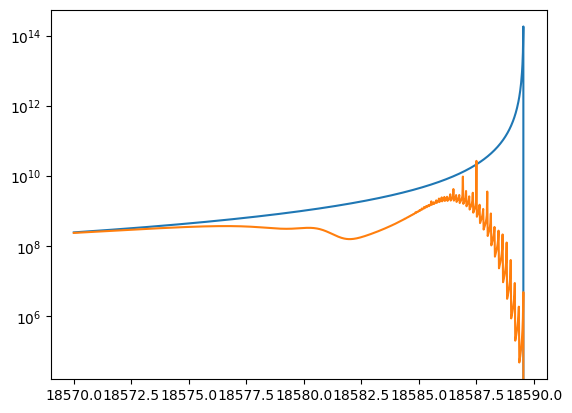

In [87]:
m_nu = 0.05
Q = 18589.6
E = np.linspace(18570, Q, 1000)

pt_norm = f_pt(18000,m_nu, Q)
beta_norm = f_beta(18000,m_nu, Q)

sp1 = ptolemy(E, coeffs, m_nu, Q)
beta = allowed_beta(E, 0)
beta_d = np.array([f_beta(e,m_nu, Q) for e in E])
pt_d = np.array([f_pt(e, m_nu, Q) for e in E])

#for m in [0, 0.05, 0.1, 0.5, 1, 2]:
 #   plt.plot(E, ptolemy(E, coeffs, m, Q))
#plt.plot(E, beta/sum(beta))
#plt.plot(E, sp1/sum(sp1))
plt.plot(E, beta_d)
plt.plot(E, pt_d*beta_norm/pt_norm)
plt.yscale("log")


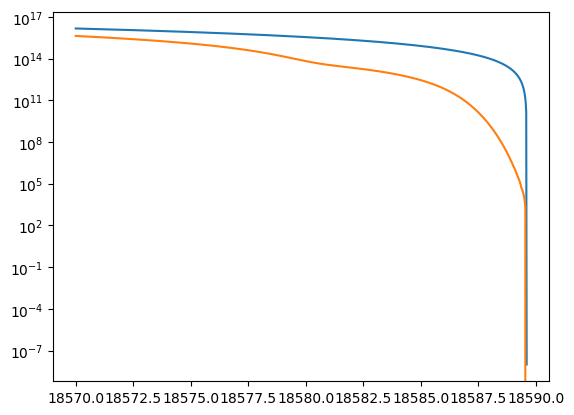

In [88]:
sp1 = ptolemy(E, coeffs, m_nu, Q)
beta = allowed_beta(E, 0)
plt.plot(E, beta)
plt.plot(E, sp1*beta_norm/pt_norm)
plt.yscale("log")

In [16]:
pt_d

array([5.36675328e+08, 5.37125413e+08, 5.37573469e+08, 5.38019466e+08,
       5.38463376e+08, 5.38905171e+08, 5.39344820e+08, 5.39782295e+08,
       5.40217566e+08, 5.40650602e+08, 5.41081373e+08, 5.41509849e+08,
       5.41935999e+08, 5.42359791e+08, 5.42781195e+08, 5.43200179e+08,
       5.43616710e+08, 5.44030756e+08, 5.44442286e+08, 5.44851265e+08,
       5.45257660e+08, 5.45661439e+08, 5.46062568e+08, 5.46461012e+08,
       5.46856738e+08, 5.47249710e+08, 5.47639893e+08, 5.48027253e+08,
       5.48411753e+08, 5.48793359e+08, 5.49172033e+08, 5.49547739e+08,
       5.49920441e+08, 5.50290100e+08, 5.50656681e+08, 5.51020145e+08,
       5.51380454e+08, 5.51737569e+08, 5.52091452e+08, 5.52442064e+08,
       5.52789365e+08, 5.53133317e+08, 5.53473877e+08, 5.53811007e+08,
       5.54144666e+08, 5.54474812e+08, 5.54801404e+08, 5.55124401e+08,
       5.55443760e+08, 5.55759440e+08, 5.56071397e+08, 5.56379588e+08,
       5.56683970e+08, 5.56984499e+08, 5.57281132e+08, 5.57573824e+08,
      

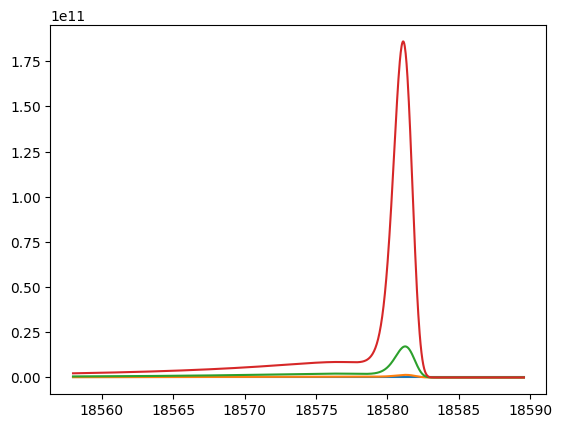

In [42]:
m_nu = 0.05
Q = 18589.6
E = np.linspace(18558, Q-m_nu, 1000)
sp1 = ptolemy(E, coeffs, m_nu, Q)
#plt.plot(E, sp1/sum(sp1))
for m in [0.001, 0.05, 0.1, 0.2]:
    d = [f(e, m, Q) for e in E]

    plt.plot(E, d)

In [176]:
ms = np.arange(0, 0.5, 0.05)
z = [[f(e, m, Q) for e in E] for m in ms]


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
  return (select([less_equal(m_nu, -E + Q),True], [-0.000686321310042043*m_nu*(1077.18092666151 - 7.61199993338816*sqrt(9.78475591779592e-7*E**2 + E))*(-E + Q)*(E + 510998.95)*sqrt(9.78475591779592e-7*E**2 + E)/sqrt(-m_nu**2 + (-E + Q)**2),0], default=nan) + select([less_equal(m_nu, -E + Q - 0.187089018191407),True], [-0.000686321310042043*m_nu*(4641.82423528311 - 32.7582039226147*sqrt(9.78475591779592e-7*E**2 + E))*(E + 510998.95)*sqrt(9.78475591779592e-7*E**2 + E)*(-E + Q - 0.187089018191407)/sqrt(-m_nu**2 + (-E + Q - 0.187089018191407)**2),0], default=nan) + select([less_equal(m_nu, -E + Q - 0.371208495956932),True], [-0.000686321310042043*m_nu*(19925.2254339711 - 140.392620690961*sqrt(9.78475591779592e-7*E**2 + E))*(E + 510998.95)*sqrt(9.78475591779592e-7*E**2 + E)*(-E + Q - 0.371208495956932)/sqrt(-m_nu**2 + (-E + Q - 0.371208495956932)**2),0], default=nan) + select([less_equal(m_nu, -E + Q - 0.552358433296

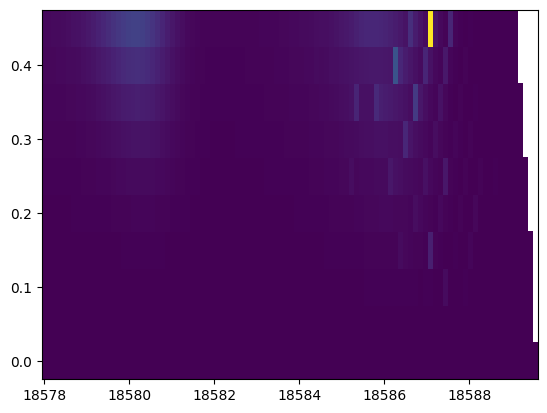

In [177]:
plt.pcolor(E, ms , z)

In [29]:
def fisher_information_density(f, x, par, **kwargs):
    dpar = par * 0.001
    return 1 / f(x, par,  **kwargs) * ((f(x, par(1+dpar),  **kwargs) - f(x, par,  **kwargs))/dpar) ** 2

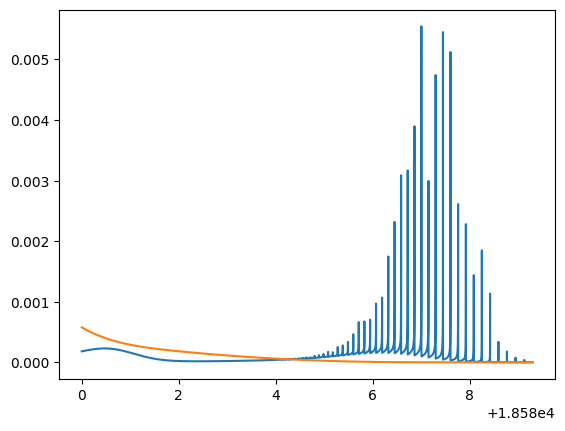

In [50]:
m_nu = 0.3
dm = 0.001
E = np.linspace(18580, 18589.6-m_nu, 10000)
sp1 = ptolemy(E, coeffs, m_nu)
sp2 = ptolemy(E, coeffs, m_nu+dm)

dens = 1/sp1 * ((sp2-sp1)/dm)**2

plt.plot(E, dens/sum(dens))
plt.plot(E, sp1/sum(sp1))

Expected number of events in ROI:  2277


<Axes: xlabel='E [eV]', ylabel='Counts'>

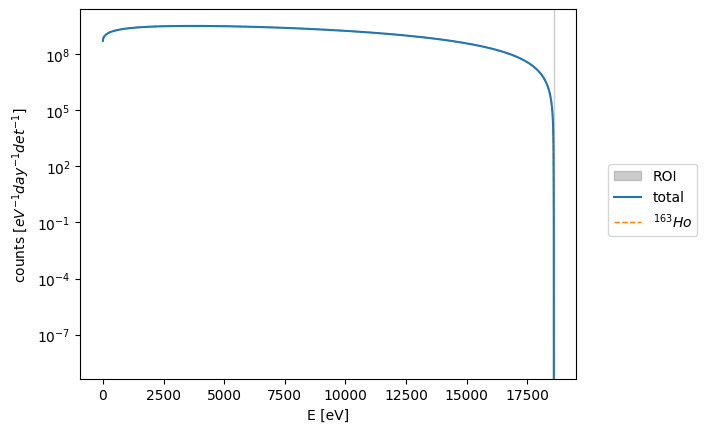

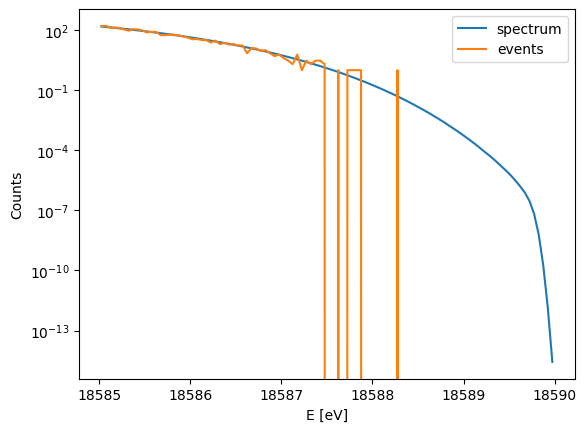

In [27]:
m = 0.05
A_T = 3.57e8 * 1
bkg = 0
FWHM= 0.1
n_days = 3* 365
coeffs = np.loadtxt("parameters.dat")[:,1:]


s = SpectraSampler({'$^{163}Ho$': [ptolemy, [coeffs, m], A_T]}, flat_bkg=bkg, FWHM=FWHM, dE=0.05, integrate=False, ROI=[18585, 18590])
s.plot_spectrum()
s.set_measure_time(n_days, n_det=1)

events = s.sample()[0]
s.plot_events(events)

/tmp/ipykernel_2115/280191025.py:5: RuntimeWarning: invalid value encountered in divide
  eta = Z* alpha * E/p


ValueError: cannot convert float NaN to integer

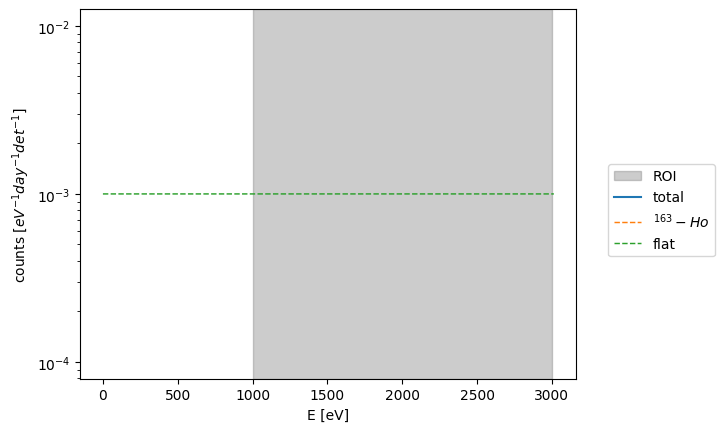

In [95]:
m = 0.05
A_T = 3.57e8 * 1
bkg = 1e-3
FWHM= 5
n_days = 3* 365


s = SpectraSampler({'$^{163}-Ho$': [allowed_beta, [0], A_T]}, flat_bkg=bkg, FWHM=FWHM, dE=0.05, integrate=False, ROI=[1000, 3000])
s.plot_spectrum()
s.set_measure_time(n_days, n_det=1)

events = s.sample()[0]
s.plot_events(events)

In [92]:
s.spectrum

{'$^{163}-Ho$': array([nan, nan, nan, ..., nan, nan, nan]),
 'flat': array([0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001])}

Found .stan file  /home/pietro/work/TESI/BAYNES/baynes/stan/models/ptolemy/ptolemy_endpoint.stan

 ---- Sampling the priors ---- 


 ---- Prior predictive check ---- 

lenghts: (2000, 100)


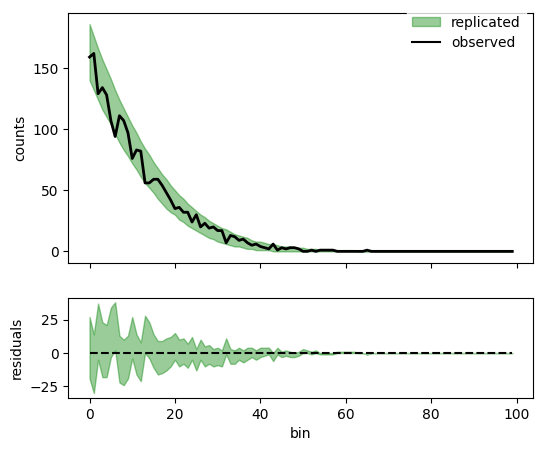


 ---- Prior distributions ---- 



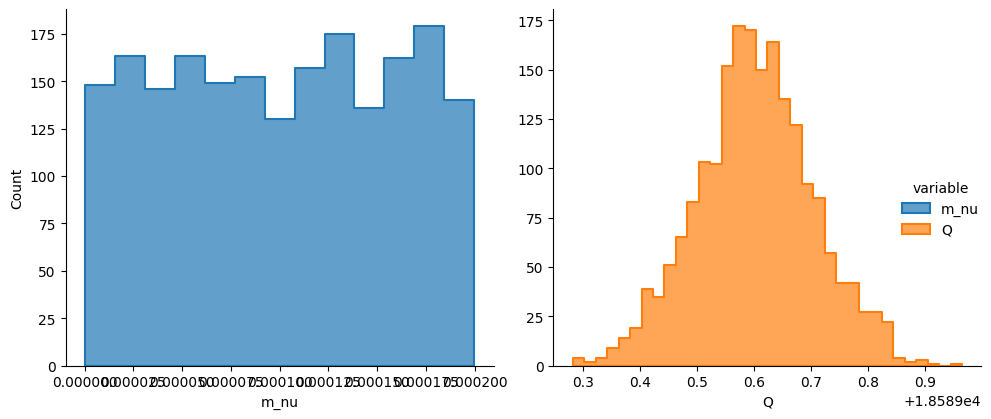


 ---- Fitting the model ---- 



chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Processing csv files: /tmp/tmprl4oa7_t/ptolemy_endpointlqpkwmky/ptolemy_endpoint-20240112100541_1.csvWarning: non-fatal error reading adaptation data
, /tmp/tmprl4oa7_t/ptolemy_endpointlqpkwmky/ptolemy_endpoint-20240112100541_2.csvWarning: non-fatal error reading adaptation data
, /tmp/tmprl4oa7_t/ptolemy_endpointlqpkwmky/ptolemy_endpoint-20240112100541_3.csvWarning: non-fatal error reading adaptation data
, /tmp/tmprl4oa7_t/ptolemy_endpointlqpkwmky/ptolemy_endpoint-20240112100541_4.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No div

/home/pietro/work/TESI/BAYNES/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/pietro/work/TESI/BAYNES/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


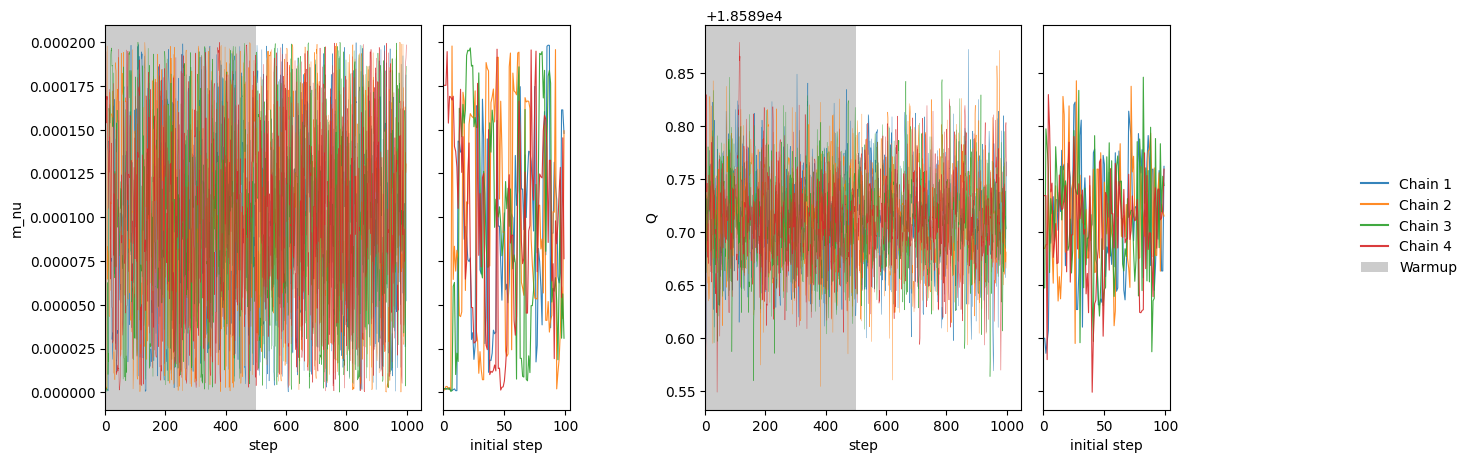


 ---- Posterior predictive check ---- 

lenghts: (2000, 100)


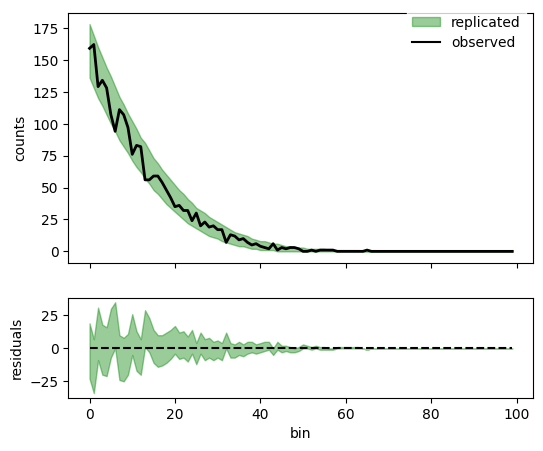


 ---- Posterior distributions ---- 



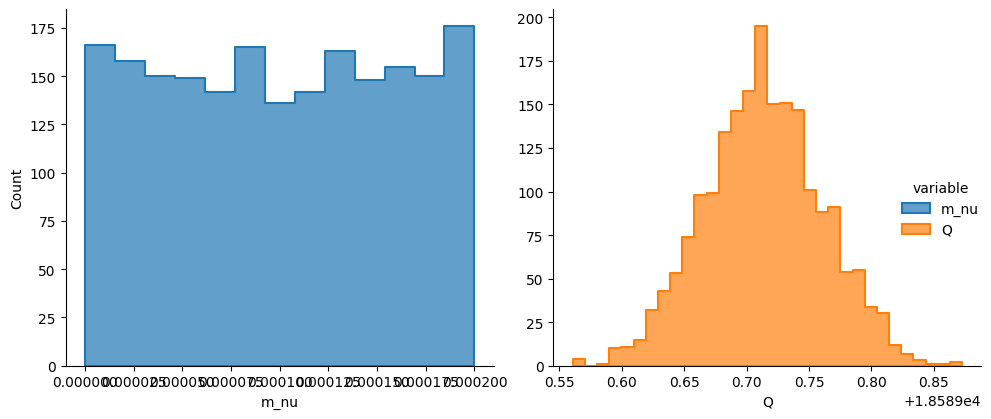


 ---- Prior vs posterior comparison ---- 



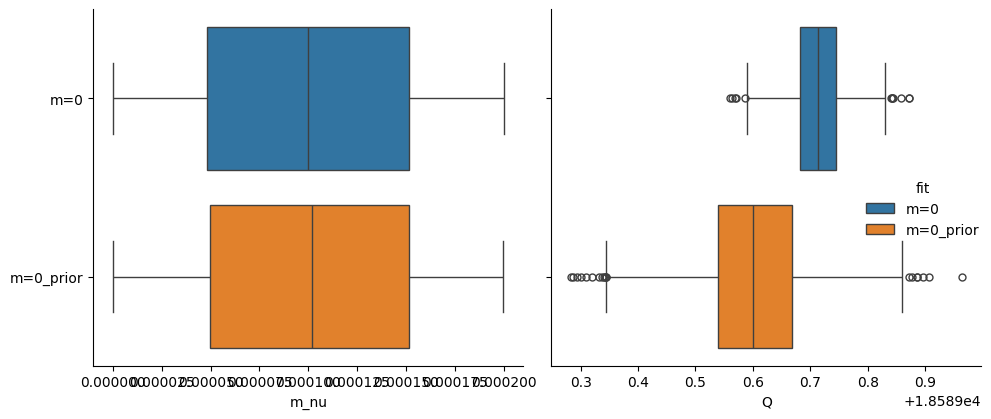

In [28]:
model= get_model("ptolemy_endpoint.stan")

data={'N_bins': len(events),
      'x': s.ROI_bin_centers,
      "N_ev": s.n_events,
      'counts': events,
      'p_Q': 18589.6,
      'p_std_Q': 0.1,
      'p_FWHM': FWHM,
      'p_std_FWHM': 0.01,
      'm_max':2e-4,
      "coeffs": coeffs,
      "prior":1
}

sampler_kwargs={
    'chains': 4,
    'iter_warmup': 500,
    'iter_sampling': 500,
    'save_warmup': True,
    'adapt_delta': 0.9,
    "sig_figs": 10,
    "show_console": False,
    "inits": {"m_red": 0.01, "z": 0, "xz":0}
}

plot_pars = ['m_nu', 'Q']
p = FitPlotter(col_wrap=4)

#fit = model.sample(data, chains=1, fixed_param=True , iter_sampling=4, iter_warmup=1)

fit = standard_analysis(model, data, p, sampler_kwargs, fit_title='m=0', plot_params = plot_pars)

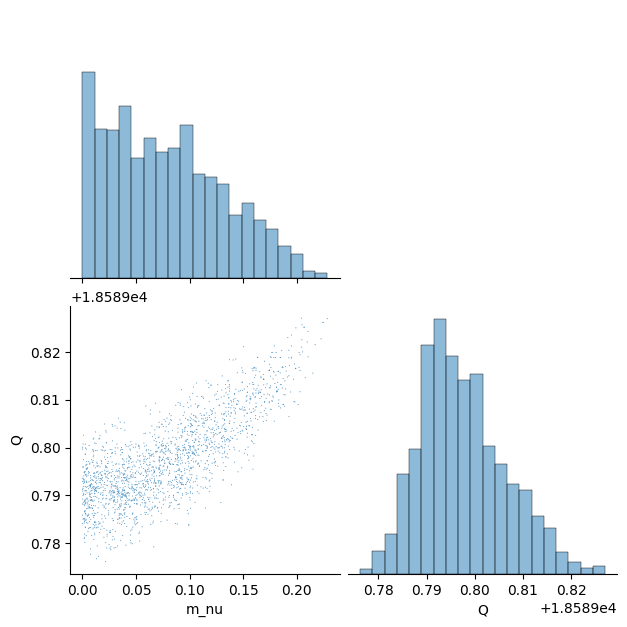

In [18]:
p.pair_grid(parameters=['m_nu', 'Q'])

In [ ]:
def nu_mass_fit(m):
    s = SpectraSampler({'$^{163}Ho$': [HoSpectrum, [m], A_Ho]}, flat_bkg=bkg, FWHM=FWHM, dE=1, integrate=False)
    s.set_measure_time(n_days, n_det=64)
    events = s.sample()[0]

    data={'N_bins': len(events),
          'x': s.ROI_bin_edges,
          'counts': events,
          'N_ev': s.n_events,
          'f_pu':0,
          'p_Q': 2833,
          'p_std_Q':35,
          'p_FWHM': FWHM,
          'p_FWHM_std':2,
          'm_max':250
    }

    inits={}
    inits['m_nu_red'] = np.random.uniform(0,20)
    inits['Q'] = np.random.normal(2833, 33)
    inits['f_bkg'] = np.random.beta(1.8, 30)
    inits['FWHM'] = np.random.normal(FWHM, 1)

    fit = model.sample(data,
                       chains=2,
                       iter_warmup=500,
                       iter_sampling=1000,
                       save_warmup=False,
                       show_progress=False,
                       inits=inits,
                       adapt_delta=0.9)
    return fit

n_fits = 100
n_processes = 16
result = multithreaded_run(nu_mass_fit, [m]*n_fits, n_processes)

In [17]:
fit.draws_pd(["counts_rep"])

,chain__,iter__,draw__,counts_rep[1],counts_rep[2],counts_rep[3],counts_rep[4],counts_rep[5],counts_rep[6],counts_rep[7],...,counts_rep[91],counts_rep[92],counts_rep[93],counts_rep[94],counts_rep[95],counts_rep[96],counts_rep[97],counts_rep[98],counts_rep[99],counts_rep[100]
0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,4.0,496.0,1996.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,4.0,497.0,1997.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,4.0,498.0,1998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,4.0,499.0,1999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
len(np.linspace(18570, 18595, 100))

100

In [29]:
len(events)

500

array([0])

## Fit of simulated $^{163}Ho$ spectrum endpoint and robust $m_\nu$ limit estimate

### Generate MC data using SpectraSampler
$$spectrum = ((1-bkg)A_{Ho}Ho(m_\nu, Q)+bkg)\otimes Normal(0, FWHM)$$


### Fit the model. The steps detailed in the previous examples are run using standard_analysis

### To obtain a robust estimate of the sensibility to $m_\nu$ the fit is repeated many times. This can be done in parallel using multithreaded_run. 

### Plot the posteriors for $m_\nu$ and combine their samples in a histogram. The upper limit on the parameter's estimate is given by the confidence interval of this distribution.

In [ ]:
posteriors = []
for fit in result:
    posteriors.append(fit.draws_pd(['m_nu']).to_numpy().flatten())
posteriors = np.array(posteriors)

ax = p.new_figure('multi').subplots()
sns.boxplot(posteriors.transpose(), whis=[2.5, 95], showfliers=False, palette='flare', ax=ax)
ax.figure.set_size_inches(25, 5)
ax.set_xticks([])
ax.set_ylabel('m_nu', fontsize=25)


full = posteriors.flatten()
ax = p.new_figure('multi').subplots()
x_max=70

prob = 0.68
print( str(prob*100) + '% highest density interval: ', hdi(full, prob=0.68))
ax.axvspan(hdi(full, prob=prob)[1], x_max, color='gray', alpha=0.2, lw=0)

prob = 0.95
print( str(prob*100) + '% highest density interval: ', hdi(full, prob=0.68))
ax.axvspan(hdi(full, prob=prob)[1], x_max, color='gray', alpha=0.2, lw=0)

sns.histplot(posteriors.transpose(), bins=100, alpha=1, multiple='stack', legend=False, lw=0., palette='flare', ax=ax)
ax.grid(False)
ax.set_xlim(0, x_max)
ax.set_xlabel('m_nu', fontsize=14)
ax.set_ylabel('counts', fontsize=14)
ax.figure.set_size_inches(8, 5)